# Dog breed classifier

## Goal of the notebook

The goal of this project is to train a classifier to recognize a dog's breed and if the dog is mixed, a proportion of each breed. 

In the end, I will try the model on different pictures of my dog, Connie, who is mixed :)


## Dataset information

Data was gathered from internet searches on a specific dog breed. Images were than downloaded and checked for accuracy as not all the images you get in a search are correct. Then the downloaded images were scanned for duplicates. All duplicates were removed to prevent any images being duplicate across the test, train and validation sets. Images were then resized to 224 X 224 X 3 and put in jpg format.

### Importing libraries

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [3]:
data_dir = os.path.join(os.getcwd(), 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
valid_dir = os.path.join(data_dir, 'valid')

### First look at the data

In [4]:
# Number of classes
n_breed = len(os.listdir(train_dir))
print(f'There are {n_breed} dog breeds in the data.')

There are 70 dog breeds in the data.


In [ ]:
# Number of images
def nb_images(dir):
    cnt = 0
    for breed_name in os.listdir(dir):
        breed_dir = os.path.join(dir, breed_name)
        n_images = len(os.listdir(breed_dir))
        cnt += n_images
    return cnt    

n_train_images = nb_images(train_dir)
n_test_images = nb_images(test_dir)
n_valid_images = nb_images(valid_dir)

print(f'There are {n_train_images} training images.')
print(f'There are {n_test_images} test images.')
print(f'There are {n_valid_images} validation images.')
print('--------------------')
print(f'There are {n_train_images + n_test_images + n_valid_images} images in total')


There are 7946 training images.
There are 700 test images.
There are 700 validation images.
--------------------
There are 9346 images in total


In [6]:
# Size of images
# According to dataset info : images were resized to 224 X 224 X 3.
# Let's check

beagle_dir = os.path.join(test_dir, 'Beagle')
beagle_img_path = os.listdir(beagle_dir)[1]
beagle_img = tf.keras.utils.load_img(os.path.join(beagle_dir,beagle_img_path))
beagle_array = tf.keras.utils.img_to_array(beagle_img)

print(f'Size of an image : {beagle_array.shape}')
#plt.imshow(beagle_img)

Size of an image : (224, 224, 3)


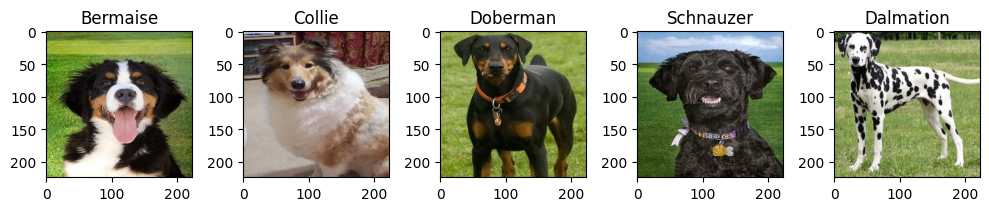

In [7]:
# Let us plot a few images labeled with their class
breeds_to_visualize = ['Bermaise', 'Collie', 'Doberman', 'Schnauzer', 'Dalmation' ]
fig, axs = plt.subplots(1, 5, figsize = (10,10))

for i in range(5):
    ax = axs[i]
    breed_dir = os.path.join(test_dir, breeds_to_visualize[i])
    ax.imshow(tf.keras.utils.load_img(os.path.join(breed_dir,os.listdir(breed_dir)[0])))
    ax.set_title(breeds_to_visualize[i])

plt.tight_layout()

### Data preprocessing

In [16]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

In [9]:
# Defining train set, test set and validation set

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    label_mode = 'categorical',
    seed = SEED
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    label_mode = 'categorical',
    seed = SEED
)

valid_set = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    label_mode = 'categorical',
    seed = SEED
)

Found 7946 files belonging to 70 classes.
Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [10]:
# Normalizing images
rescale_layer = tf.keras.layers.Rescaling(scale = 1./255)
train_set_scaled = train_set.map(lambda x,y : (rescale_layer(x),y))
test_set_scaled = test_set.map(lambda x,y : (rescale_layer(x),y))
valid_set_scaled = valid_set.map(lambda x,y : (rescale_layer(x),y))

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_set_final = (train_set_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

test_set_final = (test_set_scaled
                       .cache()
                       .prefetch(PREFETCH_BUFFER_SIZE)
                      )

# Configure the validation dataset
valid_set_final = (valid_set_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

### Building model

Let's implement a simple CNN with MaxPooling and some dropout for the latter layers

In [17]:
# Hyperparameters
n_epochs = 20
lr = 0.001

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# CNN model
cnn = Sequential([
    Input(shape = (224, 224, 3)),
    Conv2D(filters = 16, kernel_size = (3, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(filters = 32, kernel_size = (3, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    Conv2D(filters = 64, kernel_size = (3, 3)),
    MaxPooling2D(pool_size = (2, 2)),
    Flatten(),
    Dense(units = 256, activation = 'relu'),
    Dropout(rate = 0.5), 
    Dense(units = 128, activation = 'relu'),
    Dropout(rate = 0.5),
    Dense(units = 70, activation = 'softmax'),
    ])

cnn.compile(optimizer = Adam(learning_rate = lr),
            loss = 'categorical_crossentropy',
            metrics = ['accuracy']
            )

In [19]:
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    11,075,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 70)             │         9,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,141,350 (42.50 MB)

 Trainable params: 11,141,350 (42.50 MB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
from tensorflow.keras.callbacks import Callback

# Custom callback to stop the training after sufficient accucary on train set
class EarlyStoppingCallback(Callback):

    def on_epoch_end(self, epoch, logs = None):
        if logs['accuracy'] >= 0.98 :
            self.model.stop_training = True
            print('Reached 98% accuracy on train set')

In [ ]:
history_cnn = cnn.fit(
    x = train_set_final,
    validation_data = valid_set_final,
    epochs = n_epochs,
    verbose = True,
    callbacks = [EarlyStoppingCallback()]
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 148s 950ms/step - accuracy: 0.0142 - loss: 4.4475 - val_accuracy: 0.0214 - val_loss: 4.2044
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 858ms/step - accuracy: 0.0273 - loss: 4.2071 - val_accuracy: 0.0229 - val_loss: 4.1737
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 105s 842ms/step - accuracy: 0.0314 - loss: 4.1583 - val_accuracy: 0.0386 - val_loss: 4.0647
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 828ms/step - accuracy: 0.0371 - loss: 4.1060 - val_accuracy: 0.0500 - val_loss: 3.9451
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 819ms/step - accuracy: 0.0439 - loss: 4.0316 - val_accuracy: 0.0629 - val_loss: 3.8249
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 818ms/step - accuracy: 0.0481 - loss: 3.9560 - val_accuracy: 0.0657 - val_loss: 3.7586
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 874ms/step - accuracy: 0.0728 - loss: 3.8419 - val_accuracy: 0.0857 - val_loss: 3.8170
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 817ms/step - accuracy: 0.0861 -

In [65]:
# Saving the model, so we don't have to rerun the training cell in case
cnn.save('cnn_model.keras')

In [29]:
loss_test, accuracy_test = cnn.evaluate(test_set_final)
print(f'Accuracy on test set : {accuracy_test * 100:.1f} %')

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.3091 - loss: 2.8620
Accuracy on test set : 31.9 %


After trying with different structures and parameters, it seems impossible to get a test accuracy higher than 30%.
This could be expected as the classification problem is complex, the dataset not large, and the model very simple.

Let us proceed with a *transfer learning* technique by importing a model that is much more complex and suited for this task.


### Pretrained model

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Loading pretrained MobileNet model and removing its last classifier layer (classifier for 1000 classes)
MNet = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')
MNet.trainable = False

# Adding customs layers to match our breed classification problem
x = MNet.output
x = GlobalAveragePooling2D()(x)       
x = Dense(256, activation='relu')(x)  
x = Dense(128, activation='relu')(x)  
output = Dense(70, activation='softmax')(x)  

model = Model(inputs = MNet.input, outputs = output)
model.compile(optimizer = Adam(learning_rate = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [35]:
history_MNet = model.fit(
    x = train_set_final,
    validation_data = valid_set_final,
    epochs = n_epochs,
    verbose = True,
    callbacks = [EarlyStoppingCallback()]
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.5319 - loss: 2.1179 - val_accuracy: 0.8943 - val_loss: 0.6129
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.9076 - loss: 0.3124 - val_accuracy: 0.8986 - val_loss: 0.5301
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9389 - loss: 0.1948 - val_accuracy: 0.8929 - val_loss: 0.5530
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9574 - loss: 0.1393 - val_accuracy: 0.9257 - val_loss: 0.5516
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9694 - loss: 0.0925 - val_accuracy: 0.9286 - val_loss: 0.5376
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9842 - loss: 0.0552Reached 98% accuracy on train set
125/125 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - accuracy: 0.9842 - loss: 0.0552 - val_accuracy: 0.9200 - val_loss: 0.6198


In [36]:
model.save('MNet_model.keras')

In [37]:
loss_test, accuracy_test = model.evaluate(test_set_final)
print(f'Accuracy on test set : {accuracy_test * 100:.1f} %')

11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9529 - loss: 0.1738
Accuracy on test set : 94.4 %


Accuracy on the test set is close to 95%, which is much more satisfying than our previous simple CNN model. Let us now see how it performs on pictures of my dog, and what it can teach us !

#### Trying the model 

In [ ]:
# Processing images (resizing and normalizing)
def process_image(image_path):

    image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)    
    image /= 255.0
    
    return image

In [ ]:
def prediction_to_list(prediction):
    return prediction.flatten().tolist()

# For each probability, we assign the breed
def prediction_mapping(prediction_list, classes):
    res = [[0,0] for _ in range(70)]
    for i in range(70):
        res[i][0] = classes[i]
        if prediction_list[i] <= 0.1:
            res[i][1] = 0 # if the probability for a breed is less than 10%, we set it to 0
        else :
            res[i][1] = np.round(prediction_list[i] * 100, 2)
    return res

In [ ]:
# Presenting the ouput : picture on which the prediction was made and the prediction
def present_prediction(mapped_prediction, image):
    plt.imshow(image)
    plt.show()
    reduced_pred = [x for x in mapped_prediction if x[1] > 0]   
    for i in range(len(reduced_pred)):
        print(f'{reduced_pred[i][0]}: {np.round(reduced_pred[i][1])} %')

In [ ]:
# Predicting all images from a directory
def predict_dir(directory):
    for image in os.listdir(directory):
        image_path = os.path.join(directory, image)
        processed_image = process_image(image_path)
        prediction = model.predict(processed_image)
        prediction = prediction_to_list(prediction)
        mapped_pred = prediction_mapping(prediction, classes)
        present_prediction(mapped_pred, processed_image[0])

In [57]:
connie_dir = os.path.join(os.getcwd(),'Connie pictures')
classes = os.listdir(train_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


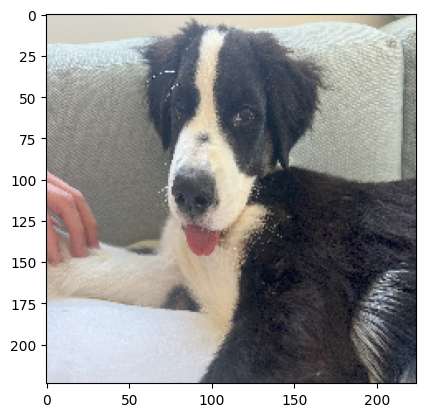

Border Collie: 95.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


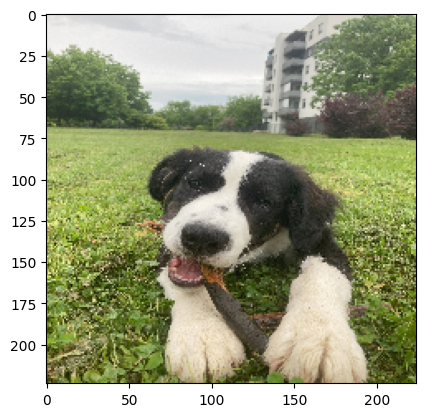

Saint Bernard: 99.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


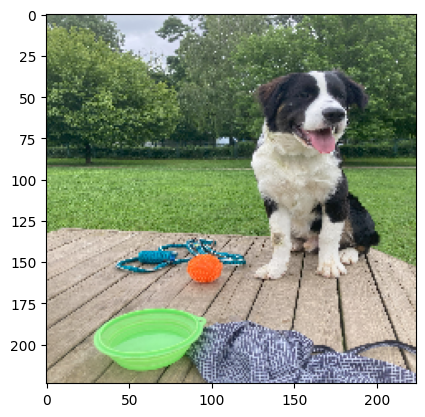

Newfoundland: 10.0 %
Saint Bernard: 83.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


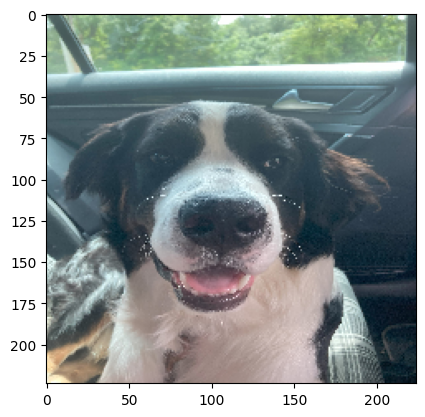

Saint Bernard: 97.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


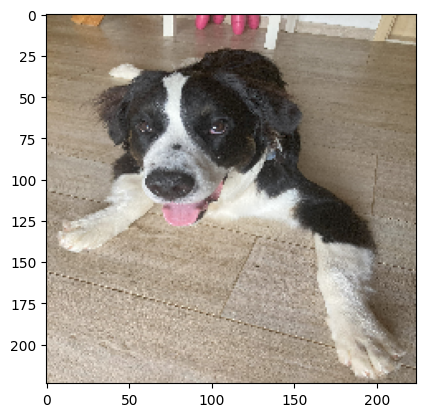

Border Collie: 50.0 %
Saint Bernard: 42.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


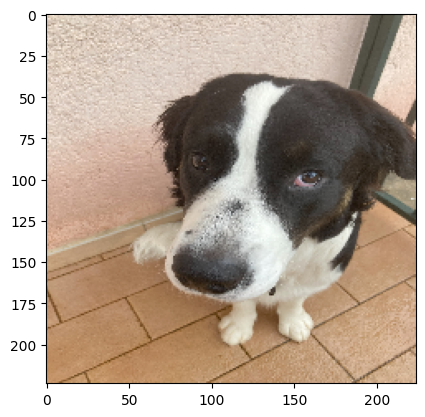

Border Collie: 77.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


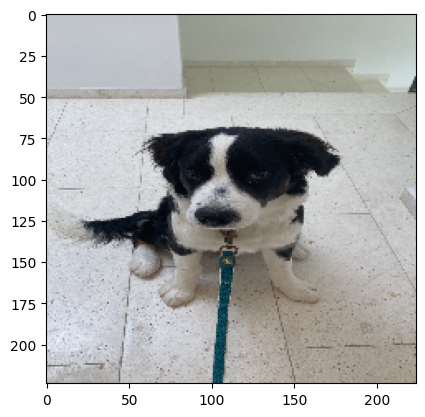

Border Collie: 77.0 %
Saint Bernard: 22.0 %


In [58]:
predict_dir(connie_dir)

I know Connie's mom to be a *rottweiler*. However, since he is from a shelter, it is impossible to know for sure the breed of his father. I suspect he is a *bernese*. Connie has some rottweiler features but looks like a bernese for the most part.

Let us see how this breed and the predicted breed look like in the data.

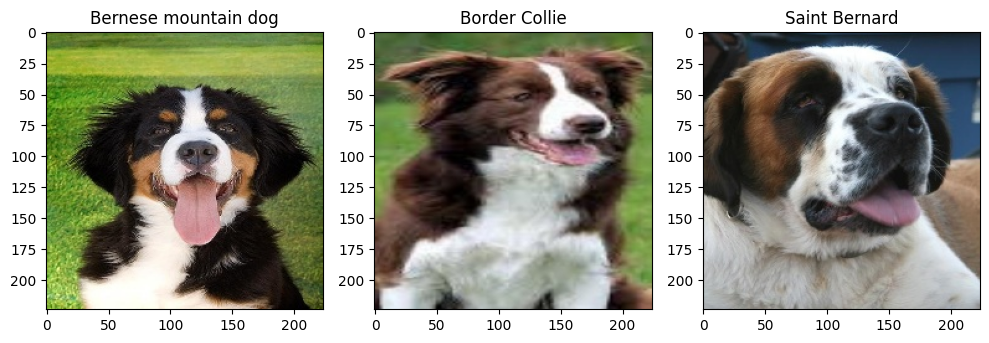

In [72]:
breeds_to_visualize = ['Bermaise', 'Border Collie', 'Saint Bernard' ]
fig, axs = plt.subplots(1, 3, figsize = (10,10))

for i in range(3):
    ax = axs[i]
    breed_dir = os.path.join(test_dir, breeds_to_visualize[i])
    ax.imshow(tf.keras.utils.load_img(os.path.join(breed_dir,os.listdir(breed_dir)[0])))
    if i < 1 :
        ax.set_title('Bernese mountain dog')
    else : 
        ax.set_title(breeds_to_visualize[i])

plt.tight_layout()

We can see these breeds look quite similar : white line on the head, same ears profile, white furry neck, and a big mouth for both bernese and saint bernard. 

It is understandable that the model learned these features and predicted a mix between *border collie* and *saint bernard* for Connie.

Fun fact : we thought he was a border collie for the first few months, sharing the same fur and colors. Then, we saw how big his paws were and knew he was going to be a big boy !

#### Perspectives for improvement

- try fine tuning models (limited on my laptop)
- try using different pretrained model such as EfficientNet,VGGNet or ResNet
- accuracy of the prediction could be higher with better quality images. We could have tried some data augmentation technique